<a href="https://colab.research.google.com/github/khodid/2020_SAI_MONING2/blob/master/myDNN_with_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 참고 소스:

- 모두의 딥러닝 시즌 2 - lab 07-2 mnist introduction
https://github.com/deeplearningzerotoall/PyTorch/blob/master/lab-07_2_mnist_introduction.ipynb

- 모두의 딥러닝 시즌 2 - 프로젝트 A
(내가 작성했던 것.)
https://github.com/khodid/2020_SAI_MONING2/blob/master/projectA_DNN.ipynb


# 패키지 받아오기.
- torch
- torch.nn : Neural Network를 위한 모델
- torchvision: datasets(Torch에서 제공되는 dataset 받아오기)/transforms( 이미지 파일 가공하기)
- matplotlib: 데이터들의 시각적 표현을 위해서.(그래프 그리기, 등등.)
- numpy: 수학 함수들 불러오기

밑에 DataLoader 패키지를 import해오는 부분도 있긴 한데, 예시에서 따로 중간에 import를 해온 것은, 아무래도 일회성으로 쓰는 것이기 때문에 읽는 사람이 이해하기 편하도록 그 패키지가 사용되는 블럭 근처에 선언을 해준 게 아닌가 싶다.

In [0]:
import torch
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


GPU를 사용하거나 CPU를 사용하도록 하는 코드...
이걸 왜 써줘야 하는 지는 예전에 설명을 들었던 것 같은데 까먹었음.

궁금해지면 'cuda'나 'gpu와 cpu' 등등의 키워드로 알아보면 될 듯.

In [0]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# 하이퍼 파라미터 설정.
- 배치 크기(미니배치 방법을 쓰기 때문)
- 학습률(learning rate): 너무 크면 overshoot이나 gradient exploding 일어나고, 작으면 학습이 더뎌서 원하는 결과가 나올 때까지 epoch 수를 늘려야 함.
- epoch: 1회의 학습 과정(cost 계산, GD에 따라 weight update) 끝나는 걸 1 epoch라고 했던 것 같다.

이 파라미터는 전부 모델을 설계하는 사람이 알아서, 감과 경험을 동원해 다르게 설정해주는 것으로 알고 있다.

In [0]:
batch_size = 50
learning_rate = 1e-3
num_of_epoch = 5

# 데이터 불러오기.

위의 참고 소스의 데이터 불러오기 파트 따라치기로 구현했음.



root : 데이터를 어디서 받아올 것인지,


trasnsform : 데이터를 어떻게 저장할 것인지.

[torchvision.transforms 라이브러리 설명](https://pytorch.org/docs/stable/torchvision/transforms.html)
- transforms.Compose 함수는 여러 가지 전처리 함수를 묶어주는 역할을 한다.
- ToTensor는 이미지 파일을 텐서로 바꾸어주는 역할
- Normalizaze 함수는 데이터를 정규분포로 바꾸어줌. 
이 정규화 전처리의 유용성은 [4월 6일 한땀한땀](https://www.notion.so/20-04-06-8c08ab4a451d4930b47d8f7191422dac#32766507a8db49ce94961f974cd9c439)에서 정리한 바 있음.

[torch.utils.data.DataLoader 파라미터 설명](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)


In [0]:
root = 'MNIST_data/'
from torch.utils.data import DataLoader

# data 가공방식 설정하기 - 프로젝트 A에서 한 것과 같이 Normalization으로 전처리 시킬 것임.
transform   = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean = (0.5,), std=(0.5,))])

# data 받아오기
train_data  = dset.MNIST(root = root, train = True,   transform = transform,  download = True)
test_data   = dset.MNIST(root = root, train = False,  transform = transform, download = True)

# data를 실제 학습과 테스트에 적용하기 위해 미니배치로 나누어주기. (매개변수로는 데이터덩어리 / 배치 크기 / 섞을지 말지)
train_loader  = DataLoader(train_data, batch_size = batch_size, shuffle = True, drop_last= True)   # 트레이닝할 때는 데이터를 섞어주지 않으면 순서 그 자체를 학습할 수도 있음.
test_loader   = DataLoader(test_data, batch_size = batch_size, shuffle = False, drop_last= True)   # 테스트 할 때는 데이터를 섞어주지 않아도 되므로.

# 데이터 샘플 시각화.

matplotlib과 numpy 쪽은 생소해서 그냥 태그랑 정렬 방식(열, 행)만 바꾸고 소스를 프로젝트 A에서 그대로 복붙했음.

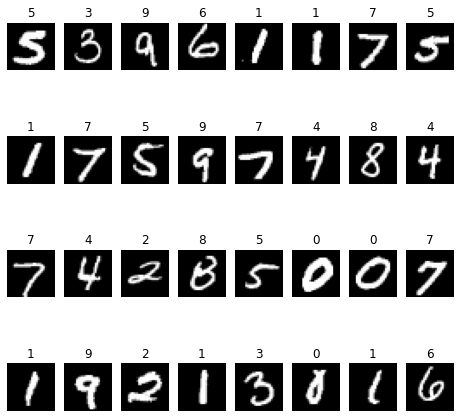

In [97]:
labels_map = {0 : '0', 1 : '1', 2 : '2', 3 : '3', 4 : '4', 5 : '5', 6 : '6',
              7 : '7', 8 : '8', 9 : '9'}
columns = 8
rows = 4
fig = plt.figure(figsize=(8,8))

for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(train_data))
    img = train_data[data_idx][0][0,:,:].numpy() # numpy()를 통해 torch Tensor를 numpy array로 변환
    label = labels_map[train_data[data_idx][1]] # item()을 통해 torch Tensor를 숫자로 변환
    
    fig.add_subplot(rows, columns, i)
    plt.title(label)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()

# 네트워크 설계

층층이 얽힌 그래프 구조를 만들어야 할 때인데...

기존에 프로젝트 A에선 layer를 2개 쌓아준 걸
3개로 늘려서 정의해보도록 하겠음.
 
 
 -> 이렇게 하니깐 밑에 학습 과정중 outputs = model(imgs) 라인에서 자꾸 tuple에는 dim이 없다는 오류가 뜸.

Module의  linear 함수에서 이런 현상이 일어나고, 

AttributeError: 'tuple' object has no attribute 'dim'

이 부분은 따라치기를 많이 했음.


In [0]:
# 3 layer Model 짜려고 했으나 오류가 나서 포기한 부분.

# class DNN(nn.Module):
#   def __init__(self, num_classes=10):
#     super(DNN, self).__init__()
#     self.layer1 = nn.Sequential(
#         nn.Linear(784, 300),      # 첫 레이어의 output 수 = 두번째 레이어의 input 수는 내 마음대로 설정했음.
#         nn.BatchNorm1d(300),
#         nn.ReLU()
#     )
#     self.layer2 = nn.Sequential(
#         nn.Linear(300, 64),         # 두번째 - 세번째 레이어 간의 연결도 내 마음대로... 
#         nn.BatchNorm1d(64),
#         nn.ReLU()
#     )
#     self.layer3 = nn.Sequential(
#         nn.Linear(64, 10)
#     )
#   def forward(self, x):
#     x = x.view(x.size(0), -1)
#     x_out = self.layer1(x)
#     x_out = self.layer2(x_out),   # 이 쪽에 파라미터를 어떤 걸 줘야하는지 약간 헷갈림. 만약 레이어 늘리기에 실패했다면 이게 원인일 가능성이 높음.
#     x_out = self.layer3(x_out)
#     return x_out

In [0]:
class DNN(nn.Module):
    def __init__(self, num_classes=10):
        super(DNN, self).__init__()
        self.layer1 = nn.Sequential(
            ## 코드 시작 ##
            nn.Linear(784, 64),    # Linear_1 해당하는 층
            torch.nn.BatchNorm1d(64),    # BatchNorm_1 해당하는 층
            torch.nn.ReLU()     # ReLU_1 해당하는 층
            ## 코드 종료 ##
        )
        self.layer2 = nn.Sequential(
            ## 코드 시작 ##
            nn.Linear(64, 10)    # Linear_2 해당하는 층 
            ## 코드 종료 ##
        )
    
    def forward(self, x):
        x = x.view(x.size(0), -1) # flatten
        x_out = self.layer1(x)
        x_out = self.layer2(x_out)
        return x_out

# Weight 초기화

DNN 에서의 Weight 초기화를 이론적으로 다룬 부분은 

[한땀한땀 4월 20일](https://www.notion.so/20-04-20-edc672e58455447a989f7f669b7beca2#edb720ded0304d13bdbb3503d6c9dffb)
에 있다.

요약하면 weight initialization은 gradient vanishing/exploding 현상을 방지하기 위해 필수적인데, 주로 쓰는 건 He나 Xavier의 방법이라는 것이다.

코드는 프로젝트 A에서 긁어 왔다.


In [0]:
def weights_init(m):
    if isinstance(m, nn.Linear): # 모델의 모든 MLP 레이어에 대해서
        nn.init.xavier_normal_(m.weight) # Weight를 xavier_normal로 초기화
        # print(m.weight)         # 프로젝트 A에 있던 line인데, 굳이 print해야 할 이유를 모르겠어서 주석처리 하겠음.

# 모델 생성

이제 지금까지 만든 레이어 구조에 weight 초기화를 넣어 학습 전의 모델 기틀을 만들어 준다.


.apply()는 torch.nn.Module 에 있는 함수? 기능? 이라고 한다.

[설명](https://pytorch.org/docs/stable/nn.html?highlight=apply#torch.nn.Module.apply) 봐도 잘 모르겠다. 객체지향 얼렁 공부해야 할 듯.

In [101]:
torch.manual_seed(7777)
model = DNN().to(device)
model.apply(weights_init)

DNN(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=10, bias=True)
  )
)

# 학습시킬 준비 - Cost function과 Optimizer 

cost 계산하는 함수(?)와 optimizer를 설정해준다.

이쪽도 코드 베끼기...

나중에 개인 프로젝트를 한다면 여기서 다른 cost function을 쓰거나 optimizer를 쓰는 시도를 할 수도 있을 것 같다.

Optimizer 관련 내용은 [4/20 스터디](https://www.notion.so/20-04-20-edc672e58455447a989f7f669b7beca2#933466115ddb4f98aabdb794f481e04f)에서 다룬 바 있다.


In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 학습시키기

프로젝트 A에서 참고 자료로 주는 것은 [이 문서](https://pytorch.org/docs/stable/optim.html#taking-an-optimization-step)다.

많이 공부해서 익숙하지만, 

**예측 -> cost 계산 -> back propagation(gradient 계산) ->gradient 업데이트**

순으로 써주면 되는 것이다.

In [103]:
for epoch in range(num_of_epoch):
    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        ## 코드 시작 ##
        outputs = model(imgs)  # 위의 설명 1. 을 참고하여 None을 채우세요.
        loss = criterion(outputs, labels)    # 위의 설명 2. 를 참고하여 None을 채우세요.
        
        optimizer.zero_grad()            # Clear gradients: 위의 설명 3. 을 참고하여 None을 채우세요.
        loss.backward()
        optimizer.step()            # Gradients 계산: 위의 설명 4. 를 참고하여 None을 채우세요.
                                    # Parameters 업데이트: 위의 설명 5. 를 참고하여 None을 채우세요.
        ## 코드 종료 ##
        
        _, argmax = torch.max(outputs, 1)
        accuracy = (labels == argmax).float().mean()
        
        if (i+1) % 300 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'.format(
                epoch+1, num_of_epoch, i+1, len(train_loader), loss.item(), accuracy.item() * 100))

Epoch [1/5], Step [300/1200], Loss: 0.3344, Accuracy: 92.00%
Epoch [1/5], Step [600/1200], Loss: 0.1647, Accuracy: 98.00%
Epoch [1/5], Step [900/1200], Loss: 0.3787, Accuracy: 88.00%
Epoch [1/5], Step [1200/1200], Loss: 0.1752, Accuracy: 96.00%
Epoch [2/5], Step [300/1200], Loss: 0.1928, Accuracy: 92.00%
Epoch [2/5], Step [600/1200], Loss: 0.1483, Accuracy: 96.00%
Epoch [2/5], Step [900/1200], Loss: 0.1171, Accuracy: 96.00%
Epoch [2/5], Step [1200/1200], Loss: 0.0887, Accuracy: 98.00%
Epoch [3/5], Step [300/1200], Loss: 0.1259, Accuracy: 94.00%
Epoch [3/5], Step [600/1200], Loss: 0.1142, Accuracy: 96.00%
Epoch [3/5], Step [900/1200], Loss: 0.0276, Accuracy: 100.00%
Epoch [3/5], Step [1200/1200], Loss: 0.1057, Accuracy: 96.00%
Epoch [4/5], Step [300/1200], Loss: 0.1771, Accuracy: 98.00%
Epoch [4/5], Step [600/1200], Loss: 0.0849, Accuracy: 98.00%
Epoch [4/5], Step [900/1200], Loss: 0.0713, Accuracy: 100.00%
Epoch [4/5], Step [1200/1200], Loss: 0.0772, Accuracy: 98.00%
Epoch [5/5], Step 

코드를 자꾸 수정하면서 계속 돌리니면 학습이 쌓여서 Accuracy가 95% 이상으로 처음부터 높게 나오는 것 같다...

실제 모델 설계할 때도 주의해야 할 점인 듯하다.

# Test하기 

이쪽도 솔직히 아직은 직접 만들 엄두는 안 나서...
따라치기 정도만 해야겠다.

Gradient 업데이트를 하면 안 되기 때문에 torch\_no\_grad를 써주고

training 과정에서 예측을 하던 부분과

Training의 진척도를 출력하는 부분을 똑같이 가져오면 되는 듯 하다.

In [104]:
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for i, (imgs, labels) in enumerate(test_loader):
    imgs, labels = imgs.to(device), labels.to(device)
    outputs = model(imgs)

    _, argmax = torch.max(outputs, 1)
    total += imgs.size(0)
    correct += (labels == argmax).sum().item()

  print("{}개 이미지에 대한 테스트 정확도: {:.3f}%".format(total, correct/total*100))

10000개 이미지에 대한 테스트 정확도: 97.360%


Overfitting 된 것일지 걱정을 좀 했는데 생각보다 좋은 모델을 만든 것 같다.

이제 이걸 시각적으로 표현하는 것만 남았는데...
솔직히 이건 따라쳐도 이해할 자신은 없다...

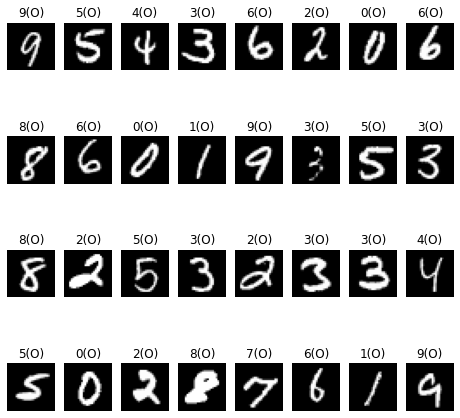

In [105]:
columns = 8
rows = 4
fig = plt.figure(figsize=(8,8))

model.eval()
for i in range(1, columns*rows+1):
    data_idx = np.random.randint(len(test_data))
    input_img = test_data[data_idx][0].unsqueeze(dim=0).to(device) 
  
    output = model(input_img)
    _, argmax = torch.max(output, 1)
    pred = labels_map[argmax.item()]
    label = labels_map[test_data[data_idx][1]]
    
    fig.add_subplot(rows, columns, i)
    if pred == label:
        plt.title(pred + '(O)')
    else:
        plt.title(pred + '(X)' + ' / ' + label)
    plot_img = test_data[data_idx][0][0,:,:]
    plt.imshow(plot_img, cmap='gray')
    plt.axis('off')
model.train()
plt.show()